In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.linalg import inv


In [2]:
#gradient
def gradG(Q,p,A,b,t,v):
    d = 1 / (b - np.dot(A, v))
    grad = t * ((Q.T + Q).dot(v) + p) + A.T.dot(d)
    return (grad)


#hessienne  
def hessianG(Q, p, A, b, t, v):
    d = 1 / (b - np.dot(A, v))
    G = (d**2)*np.eye(A.shape[0])
    return(t * (Q.T + Q) + A.T.dot(G.dot(A)))

def f(Q,p,A,b,t,v):
    if min([b[i]-A[i].dot(v) for i in range(A.shape[0])]) <= 0:
        return +1e10
    else:
        return t*v.T.dot(Q).dot(v) + t*p.T.dot(v) - sum(np.log(b - A.dot(v)))


#backtracking
def backtracking(Q,p,A,b,t,v, delta, Ndec2, alpha = 0.1, beta= 0.7):
    u = 1
    while not(((b-A.dot( v+ u * delta))>0).all()) or (f(Q,p,A,b,t, v+ u *delta) > f(Q,p,A,b,t,v) + alpha* u * (-Ndec2)):
        u = beta * u
        
    return u

In [3]:
def centering_step (Q, p, A, b, t, v0, eps):
    nitermax = 100 #seuil
    
    #on défint alpha et beta du backtracking
    alpha = 0.01
    beta = 0.5
    
    #Initialisation
    v = v0
    seq = [v]
    count = 0
    
    for i in range(nitermax):
        
        #On définit la gradient, la hessienne
        d = 1 / (b - np.dot(A, v))
        grad = gradG(Q, p, A, b, t, v)
        hess = hessianG(Q, p, A, b, t, v)

 
        #on définit delta
        L = np.linalg.cholesky(hess)
        w = np.linalg.solve(L, - grad)
        delta = np.linalg.solve(L.T, w)

        #On définit le décrément de Newton (ici on a lambda^2)
        Ndec2 = w.T.dot(w)
        
        
        if 0.5 * Ndec2 < eps :
            return (seq[-1], count)
        
        else :
            count += 1 
            u = backtracking(Q, p, A, b, t, v, delta, Ndec2, alpha, beta)
            
            #update    
            v = v + u * delta 
            seq.append(v) 

            
    return(seq[-1], count)

In [4]:
def barr_method(Q, p, A, b, v0, mu, eps=0.001):
    
    #conditions sont respectées ou pas
    if (A.dot(v0) >= b ).all() :
        return("les conditions d'inégalités ne sont pas respectées")
    
    nitermax = 100
    
    m = A.shape[0]                #nombre de contraintes (lié au problème original)
    t = 1                         #le t pour une précision epsilon
    
    seq = [v0]
    n_eps = [0]
    #barrière méthode
    
    for i in range(nitermax):
        
        #on cherche le vstar qui maximise la fonction barrière
        v, compteur = centering_step(Q, p, A, b, t, v0, eps)

        v0 = v
        seq.append(v0)
        n_eps.append(n_eps[-1]+compteur)

    
        if m/t < eps :
            return(seq, n_eps)
        
        else :
            t *= mu
            
    return (seq, n_eps)

In [7]:
n = 10
d = 50
#généré aléatoirement à partir dune loi normale(0,1)
X = np.random.randn(n,d)

#fonction de X
A = np.vstack((X.T, -X.T))

#généré aléatoirement à partir d'une loi norme (0,1)
w0 = np.random.random_sample(size = d)
y = X.dot(w0) + np.random.rand(n)
p = y

#Q fixé
Q = 0.5 * np.eye(n)

#fixe car dépend de lambda fixé
b = 10 * np.ones(2 * d)

#v0 généré aléatoirement
v0 = np.zeros(n)

eps = 0.001


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


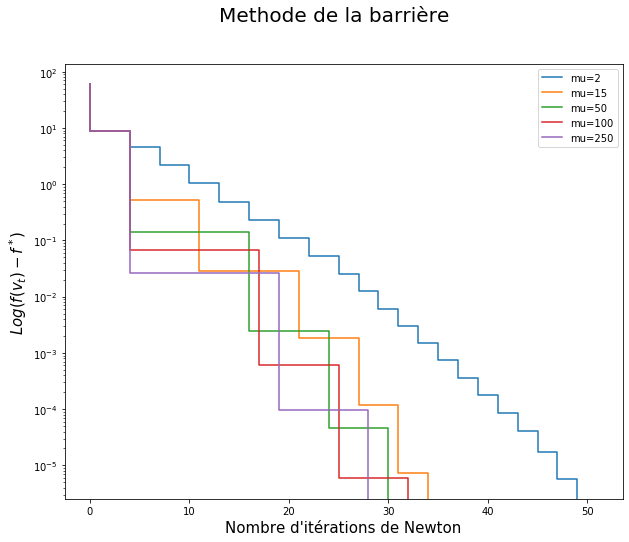

In [8]:
plt.figure(figsize=(10,8)) 
plt.suptitle('Methode de la barrière', size = 20)

for mu in [2,15,50,100,250]:
    vt, n_eps = barr_method(Q,p,A,b,v0, mu ,0.0001)
    vstar = vt[-1]
    values = [(x.T.dot(Q.dot(x)) + p.T.dot(x)) - (vstar.T.dot(Q.dot(vstar)) + p.T.dot(vstar)) for x in vt]
    plt.step(n_eps, values, label='mu='+str(mu))
    
plt.legend(loc = 'upper right')
plt.semilogy()
plt.xlabel("Nombre d'itérations de Newton", size = 15)
plt.ylabel('$Log (f(v_t)-f^*)$', size = 15)
plt.savefig("plot.eps")
plt.show()

In [24]:
#on cherche à retrouver w* qui est lié par Xwstar = vstar + y
wstar = []
for mu in [2,15,50,100,250]:
    vt, n_epsilons = barr_method(Q,p,A,b,v0, mu ,0.0001)
    vstar = vt[-1]
    wstar.append(np.linalg.lstsq(X, vstar - y, rcond = None)[0])
    
